---
Panafai
---

---
Imports
---

In [1]:
# %pip install plotly
# %pip install geopandas
# %pip install statsmodels


In [2]:
# Core data analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px  # for interactive visuals
import geopandas as gpd      # for mapping

# Modeling & stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# Utilities
import os
import warnings
warnings.filterwarnings("ignore")

# Plot settings
plt.style.use("seaborn-v0_8")
sns.set_theme(context="notebook", style="whitegrid", palette="deep")

---
## Load Data
---

In [8]:
## Load Multiple Datasets

# Full relative path
data_dir = os.path.join("Data", "MR Raw")
# Map friendly names to raw file names
files = {
    "electricity_access": "API_EG.ELC.ACCS.ZS_DS2_en_csv_v2_38353.csv",
    "mobile_subscriptions": "API_IT.CEL.SETS.P2_DS2_en_csv_v2_37045.csv",
    "internet_users": "API_IT.NET.USER.ZS_DS2_en_csv_v2_112825.csv",
    "literacy_rate": "API_SE.ADT.LITR.ZS_DS2_en_csv_v2_37553.csv"
}

# Load datasets
data = {}
for name, filename in files.items():
    path = os.path.join(data_dir, filename)
    df = pd.read_csv(path, skiprows=4)  # World Bank CSVs always start with 4 metadata rows
    data[name] = df
    print(f"Loaded {name} → {df.shape}")

# Quick preview
data["electricity_access"].head()

Loaded electricity_access → (266, 70)
Loaded mobile_subscriptions → (266, 70)
Loaded internet_users → (266, 70)
Loaded literacy_rate → (266, 70)


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2016,2017,2018,2019,2020,2021,2022,2023,2024,Unnamed: 69
0,Aruba,ABW,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,99.900000,100.000000,NaN,NaN
1,Africa Eastern and Southern,AFE,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,38.859598,40.223744,43.035073,44.390861,46.282371,48.127211,48.801258,50.668330,NaN,NaN
2,Afghanistan,AFG,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,97.700000,97.700000,93.400000,97.700000,97.700000,97.700000,85.300000,85.300000,NaN,NaN
3,Africa Western and Central,AFW,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,51.045127,48.900728,51.335829,51.291577,51.856043,54.368599,55.686683,57.069267,NaN,NaN
4,Angola,AGO,Access to electricity (% of population),EG.ELC.ACCS.ZS,NaN,NaN,NaN,NaN,NaN,NaN,...,41.800000,42.900000,45.300000,45.600000,47.000000,48.200000,48.500000,51.100000,NaN,NaN


In [9]:
# Inspect all datasets
for name, df in data.items():
    print(f"\n{name.upper()}")
    print(df.info())
    print(df.head(3))
    print("-" * 50)


ELECTRICITY_ACCESS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 70 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Name  266 non-null    object 
 3   Indicator Code  266 non-null    object 
 4   1960            0 non-null      float64
 5   1961            0 non-null      float64
 6   1962            0 non-null      float64
 7   1963            0 non-null      float64
 8   1964            0 non-null      float64
 9   1965            0 non-null      float64
 10  1966            0 non-null      float64
 11  1967            0 non-null      float64
 12  1968            0 non-null      float64
 13  1969            0 non-null      float64
 14  1970            0 non-null      float64
 15  1971            0 non-null      float64
 16  1972            0 non-null      float64
 17  1973           

In [10]:
def clean_worldbank(df, value_name, start_year=1990):
    """
    Cleans a World Bank-style dataset into long format and trims to relevant years.
    Null values are kept for later analysis.
    
    Args:
        df (pd.DataFrame): Raw dataframe
        value_name (str): Name for the indicator column
        start_year (int): First year to keep (default=1990)
    
    Returns:
        pd.DataFrame: Cleaned dataframe with columns [Country Name, Country Code, Year, value_name]
    """
    # Reshape from wide year columns to long format
    df_long = df.melt(
        id_vars=["Country Name", "Country Code"],
        var_name="Year",
        value_name=value_name
    )
    
    # Keep only numeric years
    df_long = df_long[df_long["Year"].str.isnumeric()]
    df_long["Year"] = df_long["Year"].astype(int)
    
    # Filter years
    df_long = df_long[df_long["Year"] >= start_year]
    
    # Reset index for cleanliness
    df_long = df_long.reset_index(drop=True)
    
    return df_long

In [11]:
electricity_clean = clean_worldbank(data["electricity_access"], "electricity_access")
internet_clean    = clean_worldbank(data["internet_users"], "internet_users")
mobile_clean      = clean_worldbank(data["mobile_subscriptions"], "mobile_subscriptions")
literacy_clean    = clean_worldbank(data["literacy_rate"], "literacy_rate")

# Quick check of shapes
print("Electricity:", electricity_clean.shape)
print("Internet   :", internet_clean.shape)
print("Mobile     :", mobile_clean.shape)
print("Literacy   :", literacy_clean.shape)

# Preview one dataset
electricity_clean.head()

Electricity: (9310, 4)
Internet   : (9310, 4)
Mobile     : (9310, 4)
Literacy   : (9310, 4)


,Country Name,Country Code,Year,electricity_access
0,Aruba,ABW,1990,100.0
1,Africa Eastern and Southern,AFE,1990,NaN
2,Afghanistan,AFG,1990,NaN
3,Africa Western and Central,AFW,1990,NaN
4,Angola,AGO,1990,NaN


---
## Reshape Data
---

In [12]:
## Merge Datasets
from functools import reduce

# List of cleaned datasets
dfs = [electricity_clean, internet_clean, mobile_clean, literacy_clean]

# Merge on Country Name, Country Code, Year
master_df = reduce(
    lambda left, right: pd.merge(left, right, on=["Country Name", "Country Code", "Year"], how="outer"),
    dfs
)

print("Master shape:", master_df.shape)
master_df.head()

Master shape: (9310, 7)


,Country Name,Country Code,Year,electricity_access,internet_users,mobile_subscriptions,literacy_rate
0,Afghanistan,AFG,1990,NaN,0.0,0.0,NaN
1,Afghanistan,AFG,1991,NaN,NaN,0.0,NaN
2,Afghanistan,AFG,1992,NaN,NaN,0.0,NaN
3,Afghanistan,AFG,1993,NaN,NaN,0.0,NaN
4,Afghanistan,AFG,1994,NaN,NaN,0.0,NaN


---
## EDA
---

=== Missing % by Indicator ===
Country Name             0.000000
Country Code             0.000000
Year                     0.000000
electricity_access      15.585392
internet_users          34.070892
mobile_subscriptions     9.591837
literacy_rate           75.059076
dtype: float64


=== Missing % by Year (first 10 years) ===
      Country Name  Country Code  Year  electricity_access  internet_users  \
Year                                                                         
1990           0.0           0.0   0.0           59.774436       21.804511   
1991           0.0           0.0   0.0           55.639098       85.338346   
1992           0.0           0.0   0.0           49.248120       81.203008   
1993           0.0           0.0   0.0           43.984962       75.563910   
1994           0.0           0.0   0.0           41.729323       65.789474   
1995           0.0           0.0   0.0           39.097744       48.120301   
1996           0.0           0.0   0.0         

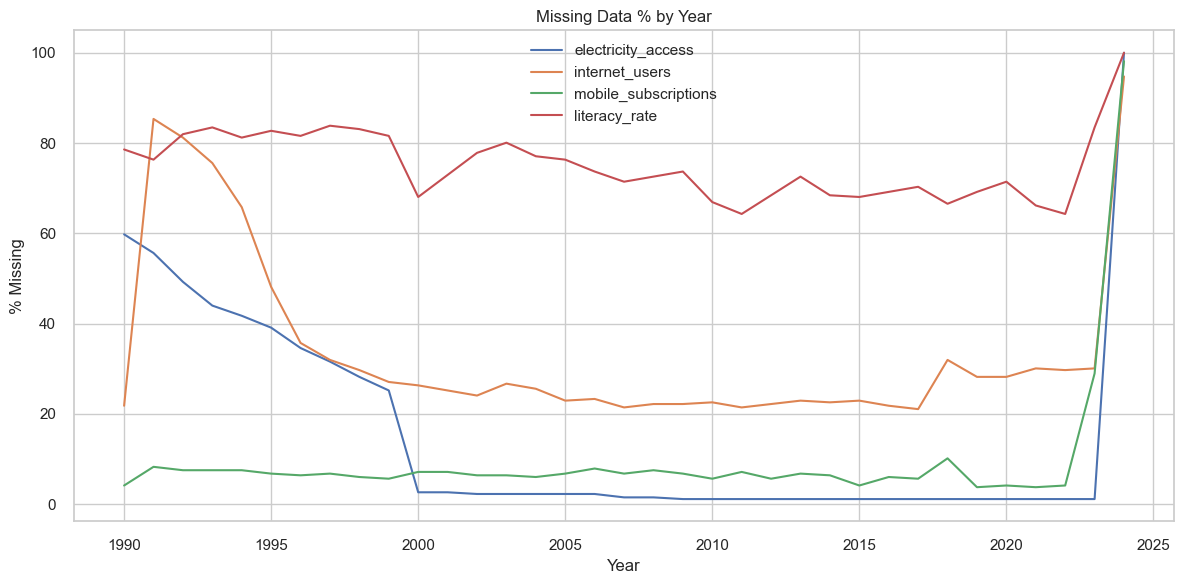

=== Missing % by Country (first 10 countries) ===
                             Country Name  Country Code  Year  \
Country Name                                                    
Afghanistan                           0.0           0.0   0.0   
Africa Eastern and Southern           0.0           0.0   0.0   
Africa Western and Central            0.0           0.0   0.0   
Albania                               0.0           0.0   0.0   
Algeria                               0.0           0.0   0.0   
American Samoa                        0.0           0.0   0.0   
Andorra                               0.0           0.0   0.0   
Angola                                0.0           0.0   0.0   
Antigua and Barbuda                   0.0           0.0   0.0   
Arab World                            0.0           0.0   0.0   

                             electricity_access  internet_users  \
Country Name                                                      
Afghanistan                        

In [16]:
## Missing Data Analysis

## Missing Data Analysis

# 1. Missingness by indicator
missing_by_indicator = master_df.isna().mean() * 100
print("=== Missing % by Indicator ===")
print(missing_by_indicator)
print("\n")

# 2. Missingness by year
missing_by_year = master_df.groupby("Year").apply(lambda x: x.isna().mean()) * 100
print("=== Missing % by Year (first 10 years) ===")
print(missing_by_year.head(10))
print("\n")

# Plot + Save
ax = missing_by_year[["electricity_access", "internet_users", "mobile_subscriptions", "literacy_rate"]].plot(
    figsize=(12,6),
    title="Missing Data % by Year"
)
plt.ylabel("% Missing")
plt.xlabel("Year")
plt.tight_layout()

# Save to images folder
os.makedirs("images", exist_ok=True)
plt.savefig("images/missingness_by_year.png", dpi=300)
plt.show()

# 3. Missingness by country
missing_by_country = master_df.groupby("Country Name").apply(lambda x: x.isna().mean()) * 100
print("=== Missing % by Country (first 10 countries) ===")
print(missing_by_country.head(10))

In [17]:
## Paring off non ISO features
import re

# Keep only rows where Country Code is a 3-letter ISO code (all letters)
master_countries = master_df[master_df["Country Code"].apply(lambda x: bool(re.match(r'^[A-Z]{3}$', str(x))))]

print("Original shape:", master_df.shape)
print("After removing aggregates:", master_countries.shape)

# Preview
master_countries.head()

Original shape: (9310, 7)
After removing aggregates: (9310, 7)


,Country Name,Country Code,Year,electricity_access,internet_users,mobile_subscriptions,literacy_rate
0,Afghanistan,AFG,1990,NaN,0.0,0.0,NaN
1,Afghanistan,AFG,1991,NaN,NaN,0.0,NaN
2,Afghanistan,AFG,1992,NaN,NaN,0.0,NaN
3,Afghanistan,AFG,1993,NaN,NaN,0.0,NaN
4,Afghanistan,AFG,1994,NaN,NaN,0.0,NaN


In [18]:
## Data was the same before and after so nothing dropped.  This is the explecit delete of non iso codes.
# Common World Bank aggregate codes we want to exclude
aggregate_codes = [
    "AFE","AFW","ARB","CEB","CSS","EAS","EAP","ECA","EMU","EUU","FCS",
    "HIC","HPC","IBD","IBT","IDA","IDB","IDX","LAC","LCN","LDC","LIC","LMC",
    "LMY","MEA","MNA","NAC","OED","OSS","PST","PRE","SAS","SSA","SSF","SST",
    "UMC","WLD"
]

# Drop aggregates
master_countries = master_df[~master_df["Country Code"].isin(aggregate_codes)].copy()

print("Original shape:", master_df.shape)
print("After removing aggregates:", master_countries.shape)

# Preview
master_countries.head()

Original shape: (9310, 7)
After removing aggregates: (8015, 7)


,Country Name,Country Code,Year,electricity_access,internet_users,mobile_subscriptions,literacy_rate
0,Afghanistan,AFG,1990,NaN,0.0,0.0,NaN
1,Afghanistan,AFG,1991,NaN,NaN,0.0,NaN
2,Afghanistan,AFG,1992,NaN,NaN,0.0,NaN
3,Afghanistan,AFG,1993,NaN,NaN,0.0,NaN
4,Afghanistan,AFG,1994,NaN,NaN,0.0,NaN


In [19]:
# Function to get the latest non-null year per country for each indicator
def latest_snapshot(df, indicators):
    """
    Extracts the most recent non-null values per country for each indicator.
    
    Args:
        df (pd.DataFrame): Cleaned country-level dataframe
        indicators (list): List of indicator column names
    
    Returns:
        pd.DataFrame: Snapshot with one row per country and latest available values
    """
    snapshot = []
    
    for country, group in df.groupby(["Country Name", "Country Code"]):
        row = {"Country Name": country[0], "Country Code": country[1]}
        
        # For each indicator, find the latest non-null value
        for ind in indicators:
            valid = group.dropna(subset=[ind])
            if not valid.empty:
                latest_row = valid.sort_values("Year", ascending=False).iloc[0]
                row[ind] = latest_row[ind]
                row[f"{ind}_year"] = latest_row["Year"]  # store year for transparency
            else:
                row[ind] = None
                row[f"{ind}_year"] = None
        
        snapshot.append(row)
    
    return pd.DataFrame(snapshot)

# Apply to our dataset
indicators = ["electricity_access", "internet_users", "mobile_subscriptions", "literacy_rate"]
snapshot_df = latest_snapshot(master_countries, indicators)

print("Snapshot shape:", snapshot_df.shape)
snapshot_df.head()

Snapshot shape: (229, 10)


,Country Name,Country Code,electricity_access,electricity_access_year,internet_users,internet_users_year,mobile_subscriptions,mobile_subscriptions_year,literacy_rate,literacy_rate_year
0,Afghanistan,AFG,85.3,2023.0,17.7,2023.0,55.54750,2023.0,37.000000,2021.0
1,Albania,ALB,100.0,2023.0,83.1,2023.0,92.99730,2023.0,98.500000,2022.0
2,Algeria,DZA,100.0,2023.0,76.9,2023.0,111.60600,2023.0,81.407837,2018.0
3,American Samoa,ASM,NaN,NaN,0.0,1990.0,3.96001,2004.0,NaN,NaN
4,Andorra,AND,100.0,2023.0,95.4,2023.0,156.09700,2023.0,NaN,NaN


In [20]:
# Average "last available year" per indicator
freshness = {}
for ind in indicators:
    freshness[ind] = snapshot_df[f"{ind}_year"].mean()

print("=== Average Latest Year by Indicator ===")
for k, v in freshness.items():
    print(f"{k}: {v:.1f}")

=== Average Latest Year by Indicator ===
electricity_access: 2022.9
internet_users: 2021.9
mobile_subscriptions: 2022.4
literacy_rate: 2019.2


In [21]:
## Normalization preparation

from sklearn.preprocessing import MinMaxScaler

# Copy snapshot
norm_df = snapshot_df.copy()

# Cap mobile subscriptions at 200
norm_df["mobile_subscriptions"] = norm_df["mobile_subscriptions"].clip(upper=200)

# Select indicators
features = ["electricity_access", "internet_users", "mobile_subscriptions", "literacy_rate"]

# Scale all indicators to 0–100
scaler = MinMaxScaler(feature_range=(0,100))
norm_df[features] = scaler.fit_transform(norm_df[features])

print("Normalized sample:")
print(norm_df[["Country Name"] + features].head())

Normalized sample:
     Country Name  electricity_access  internet_users  mobile_subscriptions  \
0     Afghanistan           84.460888            17.7             26.314779   
1         Albania          100.000000            83.1             45.417922   
2         Algeria          100.000000            76.9             54.910220   
3  American Samoa                 NaN             0.0              0.000000   
4         Andorra          100.000000            95.4             77.605079   

   literacy_rate  
0      13.366336  
1      97.937294  
2      74.433219  
3            NaN  
4            NaN  


In [22]:
# Rank countries from most to least AI ready
# Calculate composite AI Readiness Score (equal weight)
norm_df["ai_readiness_score"] = norm_df[features].mean(axis=1, skipna=True)

# Rank countries
ranked_df = norm_df.sort_values("ai_readiness_score", ascending=False)

print("Top 10 AI-Ready Countries:")
print(ranked_df[["Country Name", "ai_readiness_score"]].head(10))

print("\nBottom 10 AI-Ready Countries:")
print(ranked_df[["Country Name", "ai_readiness_score"]].tail(10))

Top 10 AI-Ready Countries:
                  Country Name  ai_readiness_score
182  Sint Maarten (Dutch part)          100.000000
98                 Isle of Man          100.000000
194   St. Martin (French part)          100.000000
39             Channel Islands          100.000000
216       United Arab Emirates           99.238977
90        Hong Kong SAR, China           98.666667
140                 Montenegro           97.099341
171         Russian Federation           95.606876
123           Macao SAR, China           95.347220
181                  Singapore           94.469761

Bottom 10 AI-Ready Countries:
                 Country Name  ai_readiness_score
31                    Burundi           28.554386
125                    Malawi           28.507032
30               Burkina Faso           25.765816
118                   Liberia           23.847498
151                     Niger           21.282380
38                       Chad           13.489834
37   Central African Republic  

In [24]:
## Africa ISO3 list
# List of African ISO country codes (54 countries)
africa_iso = [
    "DZA","AGO","BEN","BWA","BFA","BDI","CPV","CMR","CAF","TCD","COM","COG","CIV","COD","DJI",
    "EGY","GNQ","ERI","SWZ","ETH","GAB","GMB","GHA","GIN","GNB","KEN","LSO","LBR","LBY","MDG",
    "MWI","MLI","MRT","MUS","MAR","MOZ","NAM","NER","NGA","RWA","STP","SEN","SYC","SLE","SOM",
    "ZAF","SSD","SDN","TZA","TGO","TUN","UGA","ZMB","ZWE"
]

# Filter to African countries only
africa_df = ranked_df[ranked_df["Country Code"].isin(africa_iso)].copy()

print("African AI Readiness Rankings:")
print(africa_df[["Country Name", "ai_readiness_score"]].sort_values("ai_readiness_score", ascending=False).head(10))

print("\nBottom 10 African Countries:")
print(africa_df[["Country Name", "ai_readiness_score"]].sort_values("ai_readiness_score").head(10))

print("\nTotal African countries included:", africa_df["Country Name"].nunique())

African AI Readiness Rankings:
     Country Name  ai_readiness_score
179    Seychelles           93.618501
132     Mauritius           87.745820
187  South Africa           83.603313
141       Morocco           83.351750
25       Botswana           81.802939
119         Libya           81.067496
209       Tunisia           79.617816
32     Cabo Verde           78.819220
74          Gabon           76.626707
2         Algeria           76.560860

Bottom 10 African Countries:
                 Country Name  ai_readiness_score
189               South Sudan           10.247050
37   Central African Republic           13.057390
38                       Chad           13.489834
151                     Niger           21.282380
118                   Liberia           23.847498
30               Burkina Faso           25.765816
125                    Malawi           28.507032
31                    Burundi           28.554386
142                Mozambique           29.623220
66                   

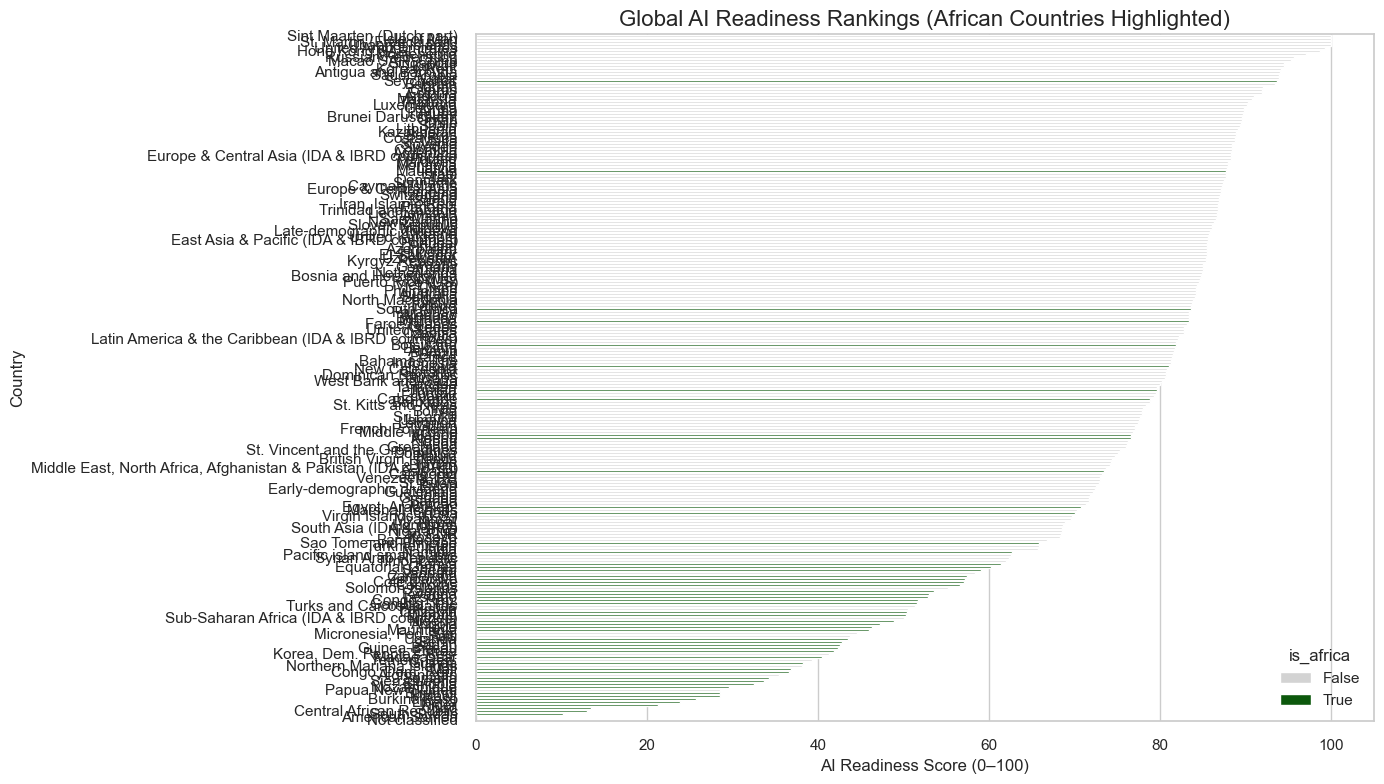

In [25]:
## Global Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Add Africa flag
ranked_df["is_africa"] = ranked_df["Country Code"].isin(africa_iso)

# Sort by readiness score
ranked_sorted = ranked_df.sort_values("ai_readiness_score", ascending=False)

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=ranked_sorted,
    x="ai_readiness_score",
    y="Country Name",
    hue="is_africa",
    dodge=False,
    palette={True: "darkgreen", False: "lightgray"}
)

plt.title("Global AI Readiness Rankings (African Countries Highlighted)", fontsize=16)
plt.xlabel("AI Readiness Score (0–100)")
plt.ylabel("Country")

# Save
os.makedirs("images", exist_ok=True)
plt.tight_layout()
plt.savefig("images/global_ai_readiness_with_africa.png", dpi=300)

plt.show()
